# Simple Convolutional Network (LeNet)

In this notebook, we will use a simple CNN (LeNet) to classify T-cell activity. The code in this notebook is similar to [simple_neural_network.ipynb](simple_neural_network.ipynb). The major differences are network generation function and network input data shape.

We will treat `learning rate` and `batch size` as two hyper-parameters, and we can use Nested Cross-Validation to tune these values and test the final models. You can learn more about the Nested Cross-Validation scheme in [logistic_regression.ipynb](logistic_regression.ipynb#1.-Nested-Cross-Validation-Scheme). We will use `Keras` with `Tensorflow` backend to implement the neural network.

## Table of Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-Preparation" data-toc-modified-id="1.-Data-Preparation-1">1. Data Preparation</a></span></li><li><span><a href="#2.-Model-Tuning/Training" data-toc-modified-id="2.-Model-Tuning/Training-2">2. Model Tuning/Training</a></span></li><li><span><a href="#3.-Model-Testing" data-toc-modified-id="3.-Model-Testing-3">3. Model Testing</a></span></li><li><span><a href="#4.-Summary" data-toc-modified-id="4.-Summary-4">4. Summary</a></span></li></ul></div>

## 1. Data Preparation

In [1]:
import numpy as np
import cv2
import re
import pandas as pd
import os
import platform
from numpy.random import seed
from glob import glob
from os.path import basename, join, exists
from collections import Counter
from json import load, dump
from sklearn import metrics
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.utils import Sequence
from tensorflow import set_random_seed
from IPython.display import display, Markdown

# Call ggplot2 code from this notebook
%load_ext rpy2.ipython

# We set a random seed to make the notebook results consistent
RANDOM_SEED = 53715
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

# Keras does not have good multithreading support for Windows
# If the current OS is Windows, we do not use multiprocessing
CUR_OS = platform.system()

Using TensorFlow backend.


We can load and group image pixel features into a dictionary. It contains both augmented and unaugmented sets.

Since we are using a convolutional network, we will represent each image as a 1-channel 3D array $\left(78, 78, 1\right)$.

In [2]:
all_data = {}
image_path = "./images/sample_images/processed/augmented/donor_{}/*/*.png"

# Load the pixel matrix for each donor
for d in [1, 2, 3, 5, 6]:
    no_aug_x, no_aug_y, no_aug_name = [], [], []
    aug_x, aug_y, aug_name = [], [], []
    
    for name in glob(image_path.format(d)):
        pixel_mat = cv2.imread(name, 0)
        pixel_feature = pixel_mat.reshape((78, 78, 1))
        
        # Add the feature and label to the correct list
        base_name = basename(name)
        cur_label = 0 if 'noact' in base_name else 1
        
        if 'r' not in base_name and 'f' not in base_name:
            no_aug_x.append(pixel_feature)
            no_aug_y.append(cur_label)
            no_aug_name.append(base_name)
        
        aug_x.append(pixel_feature)
        aug_y.append(cur_label)
        aug_name.append(base_name)

    assert(len(aug_x) == len(aug_y))
    assert(len(no_aug_x) == len(no_aug_x))
    
    # Add data for this donor
    all_data[d] = {
        'no_aug_x': np.array(no_aug_x),
        'no_aug_y': np.array(no_aug_y),
        'no_aug_name': no_aug_name,
        'aug_x': np.array(aug_x),
        'aug_y': np.array(aug_y),
        'aug_name': aug_name
    }

While training a Keras model, we want to have a mechanism to generate our dataset on multiple cores in real time and feed the model. We can make an instance of `keras.utils.Sequence` and customize the data generation rule.

In [3]:
class DataGenerator(Sequence):
    """
    Implement the DataGenertor class (instance of Sequence), so we can feed the
    training model with better parallel computing support.
    
    In this inherited class, we want to implement __getitem__ and the __len__
    methods.
    """
    
    def __init__(self, x, y, batch_size=32):
        """
        Args:
            x(array(array(78, 78, 1))): feature arrays
            y(array(n)): label array
            batch_size(int): number of training samples per epoch
        """
        
        self.x, self.y = shuffle(x, y, random_state=RANDOM_SEED)

        self.batch_size = batch_size
        self.indexes = np.arange(x.shape[0])

    def __len__(self):
        """
        This method tells keras how many times to go through the whole sample.
        """
        
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))

    def __getitem__(self, index):
        """
        This method generates one batch of data.
        
        Args:
            index(int): Current batch index
        """
        
        batch_indexes = self.indexes[index * self.batch_size:
                                     (index + 1) * self.batch_size]

        batch_x = self.x[batch_indexes, :]
        batch_y = self.y[batch_indexes, :]

        return batch_x, batch_y

Then, we want to have a wrapper to build corresponding train/validation/test data generators within the inner loop of our nested cross-validation scheme.

We use early stopping in the network training, and the early stopping criteria is based on
the performance on the validation set without augmented images. The inner loop validation set is randomly sampled from the training set. The inner loop test data are all unaugmented images from the validation donor (to evaluate hyper-parameters).

In [4]:
def partition_data_cv(all_data, test_did, vali_did, batch_size):
    """
    Function to generate all training/validation/test data to fit keras models
    following the nested cross-validation scheme. This function is only used in
    the inner CV loop.
    
    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(n,k),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(n,k),
                        'aug_y': array(n),
                        'aug_name': list(n)
                        }}
        test_did(int): donor id for test
        vali_did(int): donor id for validation
        batch_size(int): number of training sample per epoch
        
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        class_weight(dict): class weight based on label count in the traning data
        test_x(array(n,k)): feature matrix for validating the inner loop training
        test_y(array(n)): label array for validating the inner loop training
    """
            
    # Get all the non-test original names
    original_names, all_x, all_y, all_names = [], [], [], []
    for did in [i for i in [1, 2, 3, 5, 6] if i != test_did and i != vali_did]:
        original_names.extend(all_data[did]['no_aug_name'])
        all_x.extend(all_data[did]['aug_x'])
        all_y.extend(all_data[did]['aug_y'])
        all_names.extend(all_data[did]['aug_name'])
        
    # Vectorize features and labels
    all_x = np.stack(all_x, axis=0)
    all_y = np.array(all_y)
    all_names = np.array(all_names)

    # Now we randomly take 1/4 of it as validation sets
    original_names = shuffle(original_names, random_state=RANDOM_SEED)
    original_vali_names = original_names[:len(original_names) // 4]
    original_train_names = original_names[len(original_names) // 4:]

    # Only leave the prefix of the name in the sets
    vali_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                           x),
                          original_vali_names))
    train_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                            x),
                           original_train_names))

    # Put augmented images in the training set but not the validation set
    train_index, vali_index = [], []
    for i in range(len(all_names)):
        prefix = re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1', all_names[i])
        if prefix in train_prefix:
            train_index.append(i)
        elif (prefix in vali_prefix and 'r' not in all_names[i] and
              'f' not in all_names[i]):
            vali_index.append(i)

    # Fill the train/vali/test set
    train_x = all_x[train_index]
    train_y = np.vstack([[1, 0] if 'no' in name else [0, 1]
                         for name in all_names[train_index]])
    vali_x = all_x[vali_index]
    vali_y = np.vstack([[1, 0] if 'no' in name else [0, 1]
                        for name in all_names[vali_index]])

    test_x = all_data[test_did]['no_aug_x']
    test_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                        all_data[test_did]['no_aug_y']])

    # Generate the class weight based on the skewness of training set
    count = Counter([0 if 'no' in name else 1
                     for name in all_names[train_index]])
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    # We test performance on the validation set
    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            class_weight,
            test_x,
            test_y)


In [5]:
# Test partition_data_cv()
(train_gen, vali_gen, class_weight, test_x,
    test_y) = partition_data_cv(all_data, 1, 2, 32)

print('train_gen batches: {}, vali_gen batches: {}'.format(
    len(train_gen), len(vali_gen)))
print('test_x: {}, test_y: {}'.format(test_x.shape, test_y.shape))
print('class_weights: {}'.format(class_weight))

train_gen batches: 52, vali_gen batches: 3
test_x: (185, 78, 78, 1), test_y: (185, 2)
class_weights: {1: 1.3389830508474576, 0: 1.0}


## 2. Model Tuning/Training

For parameter tuning, we want a function to generate network models with given `learning rate`. The hyper-parameter `batch size` is configured in `partition_data_cv()`.

In [6]:
def get_lenet_model(lr):
    """
    Build LeNet CNN model, the structure can be found at this
    [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).
    
    LeNet has a very simple structure: Input -> Conv -> Pool -> Conv -> Pool
    -> Conv -> Hidden -> Output.
    
    Args:
        lr(float): learning rate
    
    Retruns:
        A compiled LeNet model(Keras Sequential Model).
    """

    model = Sequential()

    # C1
    model.add(Conv2D(filters=6,
                     kernel_size=5,
                     padding="same",
                     activation="relu",
                     name="C1",
                     input_shape=(78, 78, 1)))

    # S1
    model.add(MaxPooling2D(pool_size=2, strides=2, name="S2"))

    # C3
    model.add(Conv2D(filters=16,
                     kernel_size=5,
                     padding="same",
                     activation="relu",
                     name="C3"))

    # S4
    model.add(MaxPooling2D(pool_size=2, strides=2, name="S4"))

    # C5: map to 1x1 (flatten layer)
    model.add(Flatten())
    model.add(Dense(120, activation="relu", name="C5"))

    # F1/2: In original paper, there is a 84-nodes hidden layer which is
    # specialized to the MNIST dataset, we directly connect to the output
    # layer here
    model.add(Dense(2, activation="softmax", name="Output"))

    model.compile(optimizer=optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                                            epsilon=None, decay=0.0),
                  metrics=['accuracy'],
                  loss='categorical_crossentropy')
    return model


In [7]:
lenet = get_lenet_model(0.01)
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 78, 78, 6)         156       
_________________________________________________________________
S2 (MaxPooling2D)            (None, 39, 39, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 39, 39, 16)        2416      
_________________________________________________________________
S4 (MaxPooling2D)            (None, 19, 19, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5776)              0         
_________________________________________________________________
C5 (Dense)                   (None, 120)               693240    
_________________________________________________________________
Output (Dense)               (None, 2)                 242       
Total para

In [8]:
def lenet_cv(all_data, batch_size=32, lr=0.001, epoch=1000, nproc=8,
             verbose=True):
    """
    Main function to train and test a LeNet model in the Nested Cross-Validation
    inner loop. This function will have 5 x 4 = 20 runs for each given parameter
    combination.
    
    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(array(78,78,1)),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(array(78,78,1)),
                        'aug_y': array(n),
                        'aug_name': list(n)
                        }}
        batch_size(int): size of one training batch
        lr(float): learning rate
        epoch(int): max epoch to train
        nproc(int): number of jobs to run in parallel
        verbose(bool): if true, this function prints out the training process
        
    Return:
        A result dictionary containing all inner loop training results.
    """
    if verbose:
        print("Start training: lr={}, batch_size={}".format(lr, batch_size))
    # We stop training when the performance on validation set does not
    # improve in 20 continuous epochs
    early_callback = EarlyStopping(monitor='val_loss', patience=20)

    # Leave-one-donor-out 5 X 4 runs
    results = {}
    donors = [1, 2, 3, 5, 6]

    for test_did in donors:
        if verbose:
            print("\nTraining for test donor {}:".format(test_did))
        for vali_did in [i for i in donors if i != test_did]:
            if verbose:
                print("\t(vali_did: {})".format(vali_did), end='')
            # Keras would retrain the model if we are calling `fit` on the
            # same model, so we compile a new model each time before calling
            # `fit`
            model = get_lenet_model(lr)
            (train_gen, vali_gen, class_weight,
             vali_test_x, vali_test_y) = partition_data_cv(all_data,
                                                           vali_did,
                                                           test_did,
                                                           batch_size)

            # Train this model
            history = model.fit_generator(train_gen, epochs=epoch, verbose=0,
                                          callbacks=[early_callback],
                                          validation_data=vali_gen,
                                          workers=nproc,
                                          use_multiprocessing=CUR_OS!='Windows',
                                          class_weight=class_weight,
                                          shuffle=True)

            # Evaluate this model (on the inner validation set)
            vali_predict = model.predict(vali_test_x)
            vali_predict_prob = [x[1] for x in vali_predict]
            
            vali_y_1d = [np.argmax(i) for i in vali_test_y]
            vali_predict_1d = [np.argmax(i) for i in vali_predict]

            auc = metrics.roc_auc_score(vali_y_1d, vali_predict_prob)
            ap = metrics.average_precision_score(vali_y_1d, vali_predict_prob)
            acc = metrics.accuracy_score(vali_y_1d, vali_predict_1d)
            
            if verbose:
                print(" => performance (AP) = {:.2f}".format(ap))
            
            # Record the results
            results[str((test_did, vali_did))] = {
                'acc': acc,
                'ap': ap,
                'auc': auc,
                'history': history.history
            }
    return results


In [9]:
# We will use epoch = 1 here to demontrate one parameter combination training
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
result = lenet_cv(all_data, batch_size=32, lr=0.001, epoch=1, nproc=nproc)

Start training: lr=0.001, batch_size=32

Training for test donor 1:
	(vali_did: 2) => performance (AP) = 0.81
	(vali_did: 3) => performance (AP) = 0.27
	(vali_did: 5) => performance (AP) = 0.92
	(vali_did: 6) => performance (AP) = 0.43

Training for test donor 2:
	(vali_did: 1) => performance (AP) = 0.71
	(vali_did: 3) => performance (AP) = 0.88
	(vali_did: 5) => performance (AP) = 0.94
	(vali_did: 6) => performance (AP) = 0.95

Training for test donor 3:
	(vali_did: 1) => performance (AP) = 0.36
	(vali_did: 2) => performance (AP) = 0.80
	(vali_did: 5) => performance (AP) = 0.91
	(vali_did: 6) => performance (AP) = 0.94

Training for test donor 5:
	(vali_did: 1) => performance (AP) = 0.34
	(vali_did: 2) => performance (AP) = 0.82
	(vali_did: 3) => performance (AP) = 0.28
	(vali_did: 6) => performance (AP) = 0.91

Training for test donor 6:
	(vali_did: 1) => performance (AP) = 0.53
	(vali_did: 2) => performance (AP) = 0.94
	(vali_did: 3) => performance (AP) = 0.87
	(vali_did: 5) => perf

Then, we can iterate through all the hyper-parameter combinations.

In [10]:
def tune_lenet(lr_candidates, batch_size_candidates, epoch, nproc):
    """
    Grid search for the best parameter using Nested Cross-Validation.
    
    Args:
        lr_candidates([float]): learning rate candidates
        batch_size_candidates([int]): batch size candidates
        epoch(int): number of epochs to train
        nproc(int): number of paralle training jobs
        
    Return:
        Grid search result(pd.DataFrame)
    """
    
    # Record the average performance for each test donor's CV result
    tids, lrs, bss, accs, aps, aucs = [], [], [], [], [], []

    for lr in lr_candidates:
        for bs in batch_size_candidates:
            print(str((lr, bs)), end='')
            cur_result = lenet_cv(all_data, batch_size=bs, lr=lr,
                                  epoch=epoch, nproc=nproc, verbose=False)

            # Group performance results to individual test donors
            temp_result = {}
            for tid in [1, 2, 3, 5, 6]:
                temp_result[tid] = {'accs': [], 'aps': [], 'aucs': []}

            for key in cur_result:
                tid = int(re.sub(r'\((\d), \d\)', r'\1', key))
                # Collect result into corresponding test donors
                temp_result[tid]['accs'].append(cur_result[key]['acc'])
                temp_result[tid]['aps'].append(cur_result[key]['ap'])
                temp_result[tid]['aucs'].append(cur_result[key]['auc'])

            # Compute the average of performance metric
            for tid in temp_result:
                tids.append(tid)
                lrs.append(lr)
                bss.append(bs)
                accs.append(np.mean(temp_result[tid]['accs']))
                aps.append(np.mean(temp_result[tid]['aps']))
                aucs.append(np.mean(temp_result[tid]['aucs']))

    tuning_result = pd.DataFrame({
        'Test Donor': tids,
        'Learning Rate': lrs,
        'Batch Size': bss,
        'Average of Accuracy': accs,
        'Average of Average Precison': aps,
        'Average of AUC': aucs
    })
    
    return tuning_result


Here we use `epoch = 1` and reduced candidate lists to demonstrate how to run the tuning for different parameter combinations.

It is recommended to treat each parameter combination run as a job, and run all jobs independently on multiple machines.

In [11]:
# lr_candidates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# batch_size_candidates = [4, 8, 16, 32, 64, 128]

lr_candidates = [0.01]
batch_size_candidates = [64]
epoch = 1
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1

tune_lenet(lr_candidates, batch_size_candidates, epoch, nproc)

(0.01, 64)

,Test Donor,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,0.01,64,0.406179,0.559507,0.500000
1,2,0.01,64,0.537478,0.386112,0.500000
2,3,0.01,64,0.699663,0.601412,0.586697
3,5,0.01,64,0.558514,0.407172,0.500000
4,6,0.01,64,0.481394,0.481394,0.500000


We have run this grid search on sample images outside of this notebook on 30 machines with `epoch=100`. The run times vary from 30 minutes to 2.5 hours. We will use this version of `tuning_result` to choose the best parameter. The best parameter is determined by the average of average precision.

In [12]:
tuning_result = pd.read_csv('./resource/lenet_tune_result.csv')

# It has 30 * 5 = 150 rows
print(tuning_result.shape)
tuning_result.head()

(150, 6)


,Test Donor,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precision,Average of AUC
0,1,0.00001,32,0.652393,0.809405,0.733515
1,2,0.00001,32,0.694670,0.700809,0.776461
2,3,0.00001,32,0.581234,0.682011,0.667053
3,5,0.00001,32,0.630714,0.671749,0.742119
4,6,0.00001,32,0.645112,0.691443,0.722107


In [13]:
# Iterate through all the rows in the dataframe, and find the row which
# has the largest average of average precision for each test donor
best_row = {}

for i, r in tuning_result.iterrows():
    tid = r['Test Donor']
    ap = r['Average of Average Precision']
    
    if tid not in best_row:
        best_row[tid] = (i, ap)
        continue

    if ap > best_row[tid][1]:
        best_row[tid] = (i, ap)

best_para_df = tuning_result.iloc[[best_row[i][0] for i in best_row], :]

# Get the best parameter for each test donor [lr, bs, nn]
best_parameters = {}
for i, r in best_para_df.iterrows():
    best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size']]
    
best_para_df

,Test Donor,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precision,Average of AUC
10,1,0.0001,16,0.697336,0.918263,0.890846
11,2,0.0001,16,0.838988,0.854594,0.881194
27,3,0.0010,16,0.790933,0.833932,0.851892
83,5,0.0001,4,0.812944,0.874253,0.867095
29,6,0.0010,16,0.840434,0.850041,0.874816


In [14]:
best_parameters

{1.0: [0.0001, 16.0],
 2.0: [0.0001, 16.0],
 3.0: [0.001, 16.0],
 5.0: [0.0001, 4.0],
 6.0: [0.001, 16.0]}

## 3. Model Testing

After tuning `learning rate` and `batch size`, we can test the final models regarding to 5 test donors.

In this section, we will use the same `DataGenerator` class to feed Keras models. However, since we no long have to validate different parameters, we need to modify the partition function. In the below function `partition_data_test()`, we split the dataset into train/validation(early stopping)/test sets. The validation set is randomly sampled from all training images. Both train and validation set contain augmented images, and each augmented image is in the same set with its original image.

In [15]:
def partition_data_test(all_data, test_did, batch_size):
    """
    Function to generate all training/validation(early stopping)/test data to
    fit keras models for testing after cross validation.

    The validation and train set are split randomly while it guarantees that
    augmented images are partitioned with their original images. The ratio
    of train set size and validation set size is 3:1.

    Args:
        all_data(dict): a dictionary containing all augmented and unaugmented
            images and their lables
            {donor_id: {'no_aug_x': array(array(78, 78, 1)),
                        'no_aug_y': array(n),
                        'no_aug_name': list(n),
                        'aug_x': array(array(78, 78, 1)),
                        'aug_y': array(n)
                        'aug_name': list(n)
                        }}
        test_did(int): donor id for test
        batch_size(int): number of training sample per batch
            
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for early stopping
        class_weight(dict): class weight based on label count in the traning data
        test_x(array(array(78, 78, 1))): feature matrix for final testing
        test_y(array(n)): label array for final testing
    """
    # Get all the non-test original names
    original_names, all_x, all_y, all_names = [], [], [], []
    for did in [i for i in [1, 2, 3, 5, 6] if i != test_did]:
        original_names.extend(all_data[did]['no_aug_name'])
        all_x.extend(all_data[did]['aug_x'])
        all_y.extend(all_data[did]['aug_y'])
        all_names.extend(all_data[did]['aug_name'])
        
    # Vectorize features and labels
    all_x = np.array(all_x)
    all_y = np.array(all_y)

    # Now we randomly take 1/4 of it as validation sets
    original_names = shuffle(original_names, random_state=RANDOM_SEED)
    original_vali_names = original_names[:len(original_names) // 4]
    original_train_names = original_names[len(original_names) // 4:]

    # Only leave the prefix of the name in the sets
    vali_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                           x),
                          original_vali_names))
    train_prefix = set(map(lambda x: re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1',
                                           x),
                          original_train_names))

    # Put augmented images in the same set as their base images
    train_index, vali_index = [], []
    for i in range(len(all_names)):
        prefix = re.sub(r'(.+_.+_.+_.+_.+_\d+).+', r'\1', all_names[i])
        if prefix in train_prefix:
            train_index.append(i)
        elif (prefix in vali_prefix and 'r' not in all_names[i] and
              'f' not in all_names[i]):
            vali_index.append(i)

    # Fill the train/vali/test set
    train_x = all_x[train_index]
    train_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in all_y[train_index]])

    vali_x = all_x[vali_index]
    vali_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in all_y[vali_index]])

    test_x = all_data[test_did]['no_aug_x']
    test_y = np.vstack([[1, 0] if i == 0 else [0, 1] for i in
                        all_data[test_did]['no_aug_y']])
    
    # Generate the class weight based on the skewness of training set
    count = Counter(all_y[train_index])

    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    # We test performance on the validation set
    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            class_weight,
            test_x,
            test_y)

In [16]:
def make_table(metric_dict, count_dict):
    """
    Transfer the model performance metric dictionary into a Markdown table.
    
    Args:
        metric_dict(dict): a dictionary encoding model performance statisitcs
            and prediction information for all test donors
        count_dict(dict): a dinctionary encoding the count of activated and
            quiescent samples for each test donor
    
    Return:
        string: a Markdown syntax table
    """

    # Define header and line template
    table_str = ""
    line = "|{}|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{}|{}|\n"
    table_str += ("|Test Donor|Accuracy|Precision|Recall|Average Precision|" +
                  "AUC|Num of Activated|Num of Quiescent|\n")
    table_str += "|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n"

    for d in [1, 2, 3, 5, 6]:
        result = metric_dict[d]
        table_str += (line.format("donor_{}".format(d),
                                  result['acc'] * 100,
                                  result['precision'] * 100,
                                  result['recall'] * 100,
                                  result['ap'] * 100,
                                  result['aroc'] * 100,
                                  count_dict[d]['activated'],
                                  count_dict[d]['quiescent']))

    return table_str

Then, we can use the best parameters to train 5 models for 5 test donors individually.

In [17]:
def get_score(test_did, best_parameters, epoch, nproc):
    """
    Train and test using the best parameter for current test donor.
    
    Args:
        test_did(int): Test donor ID
        best_parameters(dict): The best parameter dictionary for each test donor
            {test_donor: [lr, batch_size]}
        epoch(int): number of epochs to train the model
        nproc(int): number of parallel jobs
    
    Returns:
        A dictionary containing the metrics information and predictions:
            metrics scores: ['acc': accuracy, 'precision', 'recall',
                             'ap': average precision,
                             'aroc': area under ROC curve,
                             'pr': PR curve points,
                             'roc': ROC curve points]
            predicitons: ['y_true': the groundtruth labels,
                          'y_score': predicted probability]
    """

    # Get the optimal parameter
    lr = best_parameters[test_did][0]
    batch_size = int(best_parameters[test_did][1])
    
    print("Start testing for test donor {} ".format(test_did) +
          "with parameters ({}, {})...".format(test_did, lr, batch_size))

    # Model set up
    model = get_lenet_model(lr)
    train_gen, vali_gen, class_weight, test_x, test_y = partition_data_test(
        all_data, test_did, batch_size
    )
    early_callback = EarlyStopping(monitor='val_loss', patience=20)
    
    # Train this model
    history = model.fit_generator(train_gen, epochs=epoch, verbose=0,
                                  callbacks=[early_callback],
                                  validation_data=vali_gen,
                                  workers=nproc,
                                  use_multiprocessing=CUR_OS!='Windows',
                                  class_weight=class_weight,
                                  shuffle=True)

    # Evaluate this model (on the inner validation set)
    test_predict = model.predict(test_x)
    test_predict_prob = [x[1] for x in test_predict]

    test_y_1d = [np.argmax(i) for i in test_y]
    test_predict_1d = [np.argmax(i) for i in test_predict]

    
    # Compute the PR-curve points
    precisions, recalls, thresholds = metrics.precision_recall_curve(
        test_y_1d,
        test_predict_prob,
    )

    # Compute the roc-curve points
    fprs, tprs, roc_thresholds = metrics.roc_curve(test_y_1d, test_predict_prob)
    
    # Compute other metrics
    acc = metrics.accuracy_score(test_y_1d, test_predict_1d)
    auc = metrics.roc_auc_score(test_y_1d, test_predict_prob)
    ap = metrics.average_precision_score(test_y_1d, test_predict_prob)
    print("\t=> acc={:.2f}, ap={:.2f}, auc={:.2f}\n".format(acc, ap, auc))

    return ({'acc': acc,
             'precision': metrics.precision_score(test_y_1d, test_predict_1d),
             'recall': metrics.recall_score(test_y_1d, test_predict_1d),
             'ap': ap,
             'aroc': auc,
             'pr': [precisions.tolist(), recalls.tolist(),
                    thresholds.tolist()],
             'roc': [fprs.tolist(), tprs.tolist(), roc_thresholds.tolist()],
             'y_true': test_y_1d,
             'y_score': test_predict_prob})

Here we use `epoch=1` to demonstrate how to test 5 models with their best parameters.

In [18]:
epoch = 1
nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
model_performance = {}

for test_did in [1, 2, 3, 5, 6]:
    model_performance[test_did] = get_score(test_did, best_parameters,
                                            epoch, nproc)

Start testing for test donor 1 with parameters (1, 0.0001)...
	=> acc=0.82, ap=0.48, auc=0.83

Start testing for test donor 2 with parameters (2, 0.0001)...
	=> acc=0.69, ap=0.95, auc=0.78

Start testing for test donor 3 with parameters (3, 0.001)...
	=> acc=0.94, ap=0.91, auc=0.93

Start testing for test donor 5 with parameters (5, 0.0001)...
	=> acc=0.70, ap=0.93, auc=0.82

Start testing for test donor 6 with parameters (6, 0.001)...
	=> acc=0.77, ap=0.95, auc=0.95



The testing results of `epoch=100` is included at `./resource/lenet_test_result.json`.

In [19]:
model_performance = load(open('./resource/lenet_test_result.json', 'r'))

# Change dict key from string to int (since we are loading from json)
temp_dict = {}
for k in model_performance:
    temp_dict[int(k)] = model_performance[k]
model_performance = temp_dict

print("The average of Average Precision across 5 donors is {:.2f}%.".format(
    np.mean([model_performance[i]['ap'] for i in [1, 2, 3, 5, 6]]) * 100
))

The average of Average Precision across 5 donors is 88.43%.


In [20]:
# Count the lables for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

In [21]:
# Create a table summary
display(Markdown(make_table(model_performance, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|90.00%|58.33%|63.64%|57.36%|88.64%|22|163|
|donor_2|80.00%|98.04%|76.92%|97.46%|89.33%|65|15|
|donor_3|93.57%|94.87%|80.43%|92.87%|94.99%|46|127|
|donor_5|86.96%|84.81%|100.00%|98.34%|95.82%|67|25|
|donor_6|92.16%|86.00%|97.73%|96.11%|97.92%|44|58|


The final performance of LeNet is significantly better than all linear models and simple neural network on this sample image dataset.

## 4. Summary

In this notebook, we have shown how to train, tune and test a simple CNN to classify T-cell images. Finally, we can plot the PR curve and ROC curve to study the final test performance.

In [22]:
pr_dict = {
    'method': [],
    'donor': [],
    'precision': [],
    'recall': [],
}

for d in [1, 2, 3, 5, 6]:
    pr_dict['method'].extend(['LeNet' for i in model_performance[d]['pr'][0]])
    pr_dict['donor'].extend([d for i in model_performance[d]['pr'][0]])
    pr_dict['precision'].extend(model_performance[d]['pr'][0])
    pr_dict['recall'].extend(model_performance[d]['pr'][1])

pr_df = pd.DataFrame(pr_dict)
pr_df.head()

,method,donor,precision,recall
0,LeNet,1,0.132530,1.000000
1,LeNet,1,0.127273,0.954545
2,LeNet,1,0.128049,0.954545
3,LeNet,1,0.128834,0.954545
4,LeNet,1,0.129630,0.954545


In [23]:
roc_dict = {}

roc_dict = {
    'method': [],
    'donor': [],
    'fpr': [],
    'tpr': [],
}

for d in [1, 2, 3, 5, 6]:
    roc_dict['method'].extend(['LeNet' for i in model_performance[d]['roc'][0]])
    roc_dict['donor'].extend([d for i in model_performance[d]['roc'][0]])
    roc_dict['fpr'].extend(model_performance[d]['roc'][0])
    roc_dict['tpr'].extend(model_performance[d]['roc'][1])

roc_df = pd.DataFrame(roc_dict)
roc_df.head()

,method,donor,fpr,tpr
0,LeNet,1,0.000000,0.000000
1,LeNet,1,0.012658,0.181818
2,LeNet,1,0.012658,0.363636
3,LeNet,1,0.031646,0.363636
4,LeNet,1,0.031646,0.409091


/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


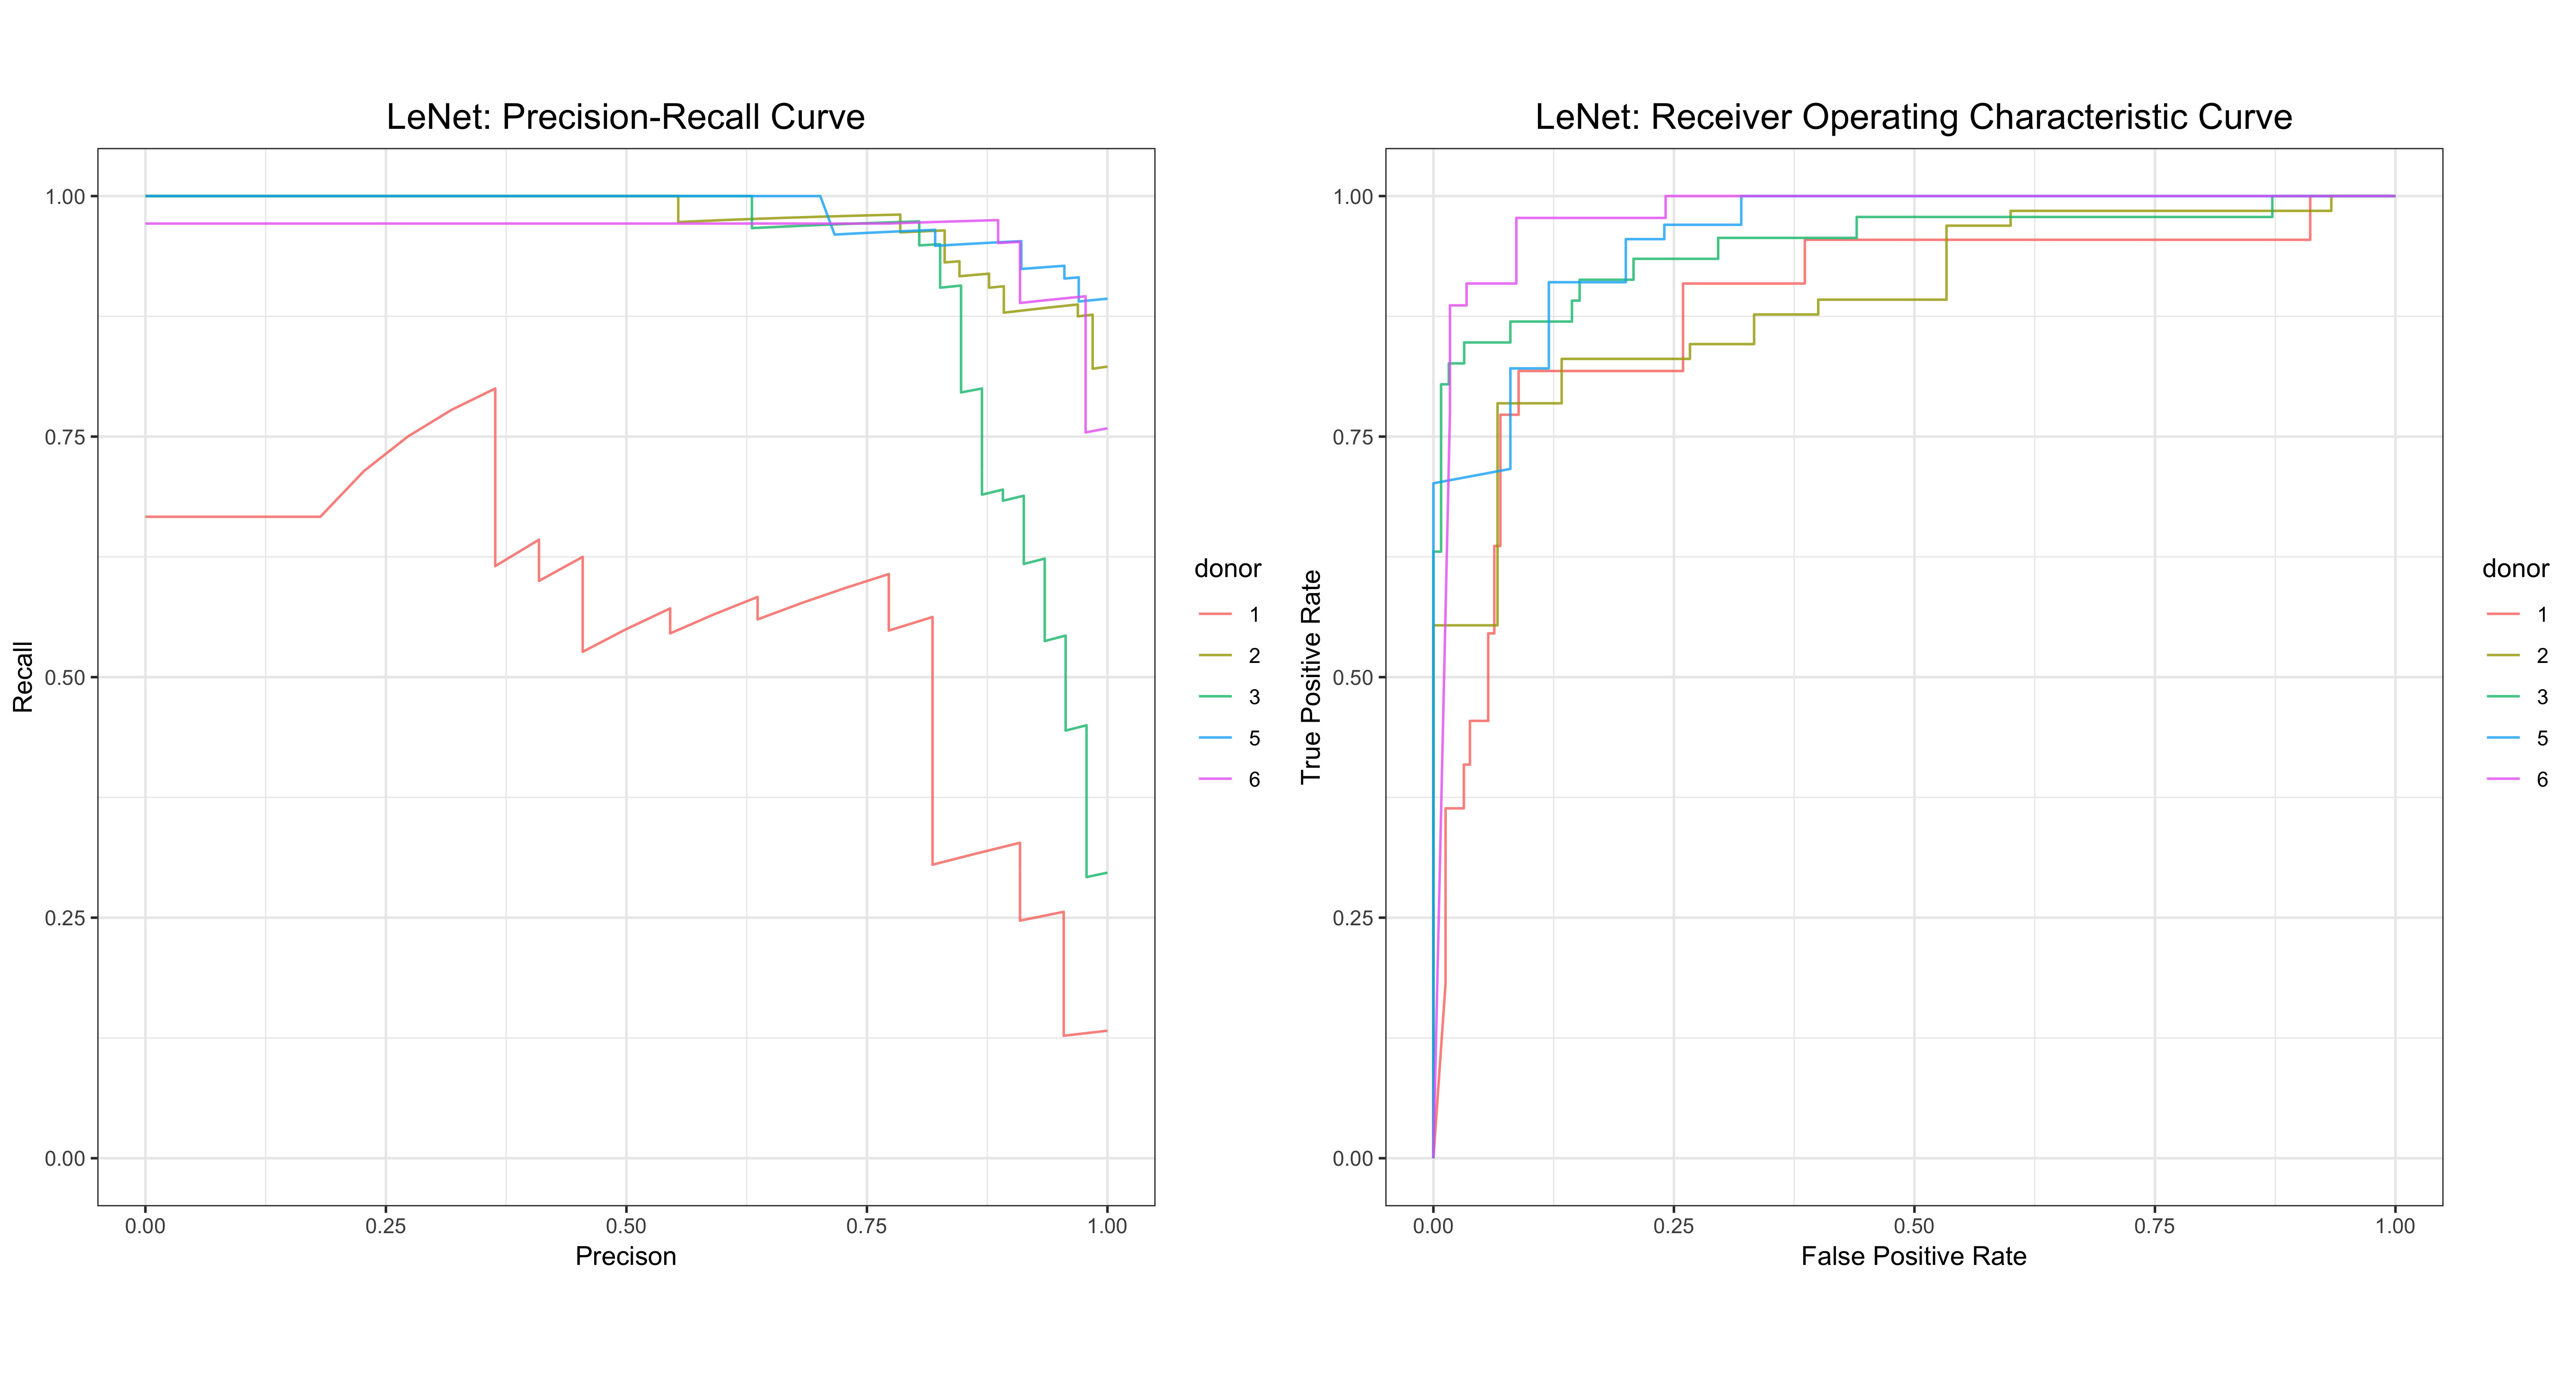

In [24]:
%%R -i pr_df,roc_df -w 15 -h 8 --units in -r 400

library("magrittr")
library("ggplot2")
library("ggpubr")

pr_df$donor = factor(pr_df$donor)
roc_df$donor = factor(roc_df$donor)

for (d in c(1, 2, 3, 5, 6)){
    inx = which(pr_df$donor == d)
    # Not plot the last arbitary precision (1, created by numpy)
    pr_df$precision[tail(inx, n=1)] = pr_df$precision[tail(inx, n=2)[1]]
}

# Draw the PR-curve
p1 = ggplot(pr_df, aes(x=recall, y=precision, group=donor, color=donor)) +
    geom_path(size=0.5, alpha=0.8) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15),
          legend.position = "right") +
    ylim(0, 1) +
    xlab("Precison") + ylab("Recall") +
    coord_fixed() +
    ggtitle("LeNet: Precision-Recall Curve")

# Draw the ROC-curve
p2 = ggplot(roc_df, aes(x=fpr, y=tpr, group=donor, color=donor)) +
    geom_path(size=0.5, alpha=0.8) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15),
          legend.position = "right") +
    ylim(0, 1) +
    xlab("False Positive Rate") + ylab("True Positive Rate") +
    coord_fixed() +
    ggtitle("LeNet: Receiver Operating Characteristic Curve")

ggarrange(p1, p2, ncol=2)

Similarly to the PR curve of simple neural network, LeNet is struggling to predict images from Donor 1 and Donor 3. The reason might be these two donors have the most images, so they have less training/tuning samples than other test donors.